# Database Systems - Homework Assignment 2 - Part 1
University of Aveiro 


This notebook shows how to read a csv file and import the data into a relational database. 
Inserting a large amount of data via pyodbc can be extremely slow. For more information, see https://stackoverflow.com/questions/5693885/pyodbc-very-slow-bulk-insert-speed. There are tools developed specifically for extracting, transforming and loading (ETL) data into databases, but this topic is outside the scope of this class.

### Importing data from a csv file into Postgres
The first example shows how to read the file using a csv.reader.

SEE: https://zetcode.com/python/psycopg2/

# Importação de Pacotes

In [66]:
import numpy as np
import pandas as pd
import os
import math
import csv
import psycopg2 as pg
import chardet

# seed the pseudorandom number generator
from random import seed
from random import random
from random import randint

import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.legend import Legend

# Preenchimento com informação aleatória da tabela student

In [67]:
# simulate students data: id, gender, age_group, year, area
nr_students = 20
ids = [] 
gender = []
age_groups = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
age_group = []
year = []
areas = ['social sciences','life sciences','engineering','mathematics']
area = []
seed(1) 
for i in range(0,nr_students):
    ids.append(randint(100001, 200000))
    gender.append('M' if random() > 0.5 else 'F')
    r_age = random()
    age_group.append(age_groups[0] if r_age <= 0.5 else age_group[1] if r_age <= 0.75 else age_groups[2] if r_age <= 0.85 else age_groups[3] if r_age <= 0.95 else age_groups[4] if r_age <= 0.98 else age_groups[5])
    year.append(randint(1, 5))
    r_area = randint(0,3)
    area.append(areas[0] if r_area == 0 else areas[1] if r_area == 1 else areas[2] if r_area == 2 else areas[3])

dictionary_students = { 'id': ids, 'gender': gender, 'age_group': age_group, 'year': year, 'area': area }

df_student = pd.DataFrame(dictionary_students)

df_student

,id,gender,age_group,year,area
0,117612,M,35-44,1,engineering
1,115456,F,18-24,4,life sciences
2,112303,F,45-54,4,mathematics
3,179619,M,18-24,4,engineering
4,194574,M,18-24,1,engineering
5,104010,F,18-24,1,mathematics
6,189979,F,18-24,1,life sciences
7,157395,M,18-24,3,life sciences
8,188716,F,18-24,3,social sciences
9,154550,M,18-24,1,life sciences


# Comandos em PostgreSQL para criar as bases de dados e populá-las

In [68]:
con = pg.connect(user="postgres",
                password="pa55word",
                host="127.0.0.1",
                port="5432",
                database="ha2")

cursor = con.cursor()

create_database = """
                    DROP TABLE IF EXISTS public.student CASCADE;

                    CREATE TABLE public.student
                    (
                        student_id character varying(3) NOT NULL,
                        id integer NOT NULL,
                        gender character(1) COLLATE pg_catalog."default",
                        age_group character varying(7) COLLATE pg_catalog."default",
                        year integer,
                        area character varying(20) COLLATE pg_catalog."default",
                        UNIQUE(id),
                        CONSTRAINT "PK_student" PRIMARY KEY (student_id)
                    );

                    DROP TABLE IF EXISTS public.dinning CASCADE;

                    CREATE TABLE public.dinning
                    (
                        student_id character varying(3) COLLATE pg_catalog."default" NOT NULL,
                        date timestamp without time zone NOT NULL,
                        company character varying(50) COLLATE pg_catalog."default",
                        meal character varying(50) COLLATE pg_catalog."default",
                        CONSTRAINT dinning_pkey PRIMARY KEY (student_id, date),
                        CONSTRAINT FK_dinning_students FOREIGN KEY (student_id) REFERENCES student (student_id)
                    );

                    DROP TABLE IF EXISTS public.grades CASCADE;

                    CREATE TABLE public.grades
                    (
                        student_id character varying(3) COLLATE pg_catalog."default" NOT NULL,
                        gpa_all double precision,
                        gpa_13s double precision,
                        cs_65 double precision,
                        CONSTRAINT "PK_grades" PRIMARY KEY (student_id),
                        CONSTRAINT FK_grades_students FOREIGN KEY (student_id) REFERENCES student (student_id)
                    );

                    DROP TABLE IF EXISTS public.perceivedstressscale CASCADE;

                    CREATE TABLE public.perceivedstressscale
                    (
                        student_id character varying(3) COLLATE pg_catalog."default" NOT NULL,
                        type character varying(5) COLLATE pg_catalog."default" NOT NULL,
                        q1 character varying(50) COLLATE pg_catalog."default",
                        q2 character varying(50) COLLATE pg_catalog."default",
                        q3 character varying(50) COLLATE pg_catalog."default",
                        q4 character varying(50) COLLATE pg_catalog."default",
                        q5 character varying(50) COLLATE pg_catalog."default",
                        q6 character varying(50) COLLATE pg_catalog."default",
                        q7 character varying(50) COLLATE pg_catalog."default",
                        q8 character varying(50) COLLATE pg_catalog."default",
                        q9 character varying(50) COLLATE pg_catalog."default",
                        q10 character varying(50) COLLATE pg_catalog."default",
                        CONSTRAINT "PK_stress" PRIMARY KEY (student_id,type),
                        CONSTRAINT FK_perceivedstressscale_students FOREIGN KEY (student_id) REFERENCES student (student_id)
                    );

                    DROP TABLE IF EXISTS public.panas CASCADE;

                    CREATE TABLE public.panas
                    (
                        student_id character varying(3) COLLATE pg_catalog."default" NOT NULL,
                        type character varying(5) COLLATE pg_catalog."default" NOT NULL,
                        interested integer,
                        distressed integer,
                        upset integer,
                        strong integer,
                        guilty integer,
                        scared integer,
                        hostile integer,
                        enthusiastic integer,
                        proud integer,
                        irritable integer,
                        alert integer,
                        inspired integer,
                        nervous integer,
                        determined integer,
                        attentive integer,
                        jittery integer,
                        active integer,
                        afraid integer,
                        CONSTRAINT "PK_panas" PRIMARY KEY (student_id, type),
                        CONSTRAINT FK_panas_students FOREIGN KEY (student_id) REFERENCES student (student_id)
                    );


                  """

cursor.execute(create_database)

ustd = []
stdid = 1
for raw in range(len(df_student)):
    if stdid == 6:
        stdid += 1
    u = "u0" + str(stdid) if len(str(stdid)) == 1 else "u" + str(stdid)
    insert = "INSERT INTO public.student(student_id, id, gender, age_group, year, area) VALUES('" + u + "', " + str(df_student["id"].iloc[raw]) + ", '" + str(df_student["gender"].iloc[raw]) + "', '" + str(df_student["age_group"].iloc[raw]) + "', " + str(df_student["year"].iloc[raw]) + ", '" + str(df_student["area"].iloc[raw]) + "');"
    cursor.execute(insert)
    ustd.append(u)
    stdid += 1
          
print(f'Processed {raw+1} lines.')

Processed 20 lines.


# Popular a tabela dinning

In [69]:
for std in ustd:
    try:
        with open(os.getcwd() + '\\dataset\\dinning\\' + std + '.txt', 'rb') as f:
            result = chardet.detect(f.read(100000))
        with open(os.getcwd() + '\\dataset\\dinning\\' + std + '.txt', 'r', encoding = result['encoding']) as f:	
            linhas = f.readlines()
            for linha in linhas:
                l = linha.strip().split(',')
                insert = "INSERT INTO public.dinning VALUES('" + std + "', CAST('" + l[0] + "' AS TIMESTAMP), '" + l[1] + "', '" + l[2] + "');"
                cursor.execute(insert)
    except:
        print("There is no information about", std)

    con.commit()


There is no information about u03
There is no information about u11
There is no information about u13
There is no information about u17
There is no information about u21


# Popular a tabela grades

In [70]:
with open(os.getcwd() + '\\dataset\\education\\grades.csv', 'rb') as f:
    result = chardet.detect(f.read(100000))
with open(os.getcwd() + '\\dataset\\education\\grades.csv', 'r') as f:	
    linhas = f.readlines()
    cnt = 1
    for linha in linhas: 
        l = linha.strip().split(',')
        if cnt > 1 and l[0] in ustd :
            insert = "INSERT INTO public.grades VALUES('" + l[0] + "', " + l[1] + ", " + l[2] + ", " + l[3] + ");"
            cursor.execute(insert)
        cnt += 1
    con.commit()

# Popular a tabela PerceivedStressScale

In [71]:
with open(os.getcwd() + '\\dataset\\survey\\PerceivedStressScale.csv', 'rb') as f:
    result = chardet.detect(f.read(100000))
with open(os.getcwd() + '\\dataset\\survey\\PerceivedStressScale.csv', 'r') as f:	
    linhas = f.readlines()
    cnt = 1
    for linha in linhas: 
        l = linha.strip().split(',')
        if cnt > 1 and l[0] in ustd :
            insert = "INSERT INTO public.perceivedstressscale VALUES('" + l[0] + "', '" + l[1] + "', '" + l[2] + "', '" + l[3] + "', '" + l[4] + "', '" + l[5] + "', '" + l[6] + "', '" + l[7] + "', '" + l[8] + "', '" + l[9] + "', '" + l[10] + "', '" + l[11] + "');"
            cursor.execute(insert)
        cnt += 1
    con.commit()

# Popular a tabela panas

In [72]:
with open(os.getcwd() + '\\dataset\\survey\\panas.csv', 'rb') as f:
    result = chardet.detect(f.read(100000))
with open(os.getcwd() + '\\dataset\\survey\\panas.csv', 'r') as f:	
    linhas = f.readlines()
    cnt = 1
    for linha in linhas: 
        l = linha.strip().split(',')
        if cnt > 1 and l[0] in ustd :
            insert = "INSERT INTO public.panas VALUES('" + l[0] + "', '" + l[1] + "', '" + l[2] + "', '" + l[3] + "', '" + l[4] + "', '" + l[5] + "', '" + l[6] + "', '" + l[7] + "', '" + l[8] + "', '" + l[9] + "', '" + l[10] + "', '" + l[11] + "', '" + l[12] + "', '" + l[13] + "', '" + l[14] + "', '" + l[15] + "', '" + l[16] + "', '" + l[17] + "', '" + l[18] + "', '" + l[19] + "');"
            cursor.execute(insert)
        cnt += 1
    con.commit()

# Fechar a ligação

In [73]:
con.close()

# Gráfico do GPA médio por área de estudo 

In [74]:
try:
    connection = pg.connect(user="postgres",
                                  password="pa55word",
                                  host="127.0.0.1",
                                  port="5432",
                                  database="ha2")

    df_grades = pd.read_sql("Select * from grades g inner join student s on g.student_id = s.student_id", connection)

except Exception as error:
    print ("Oops! An exception has occured:", error)
    print ("Exception TYPE:", type(error))
finally:
    if connection:
        connection.close()
        print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [75]:
avg_grades = df_grades[["area", "gpa_all"]].groupby("area").mean()


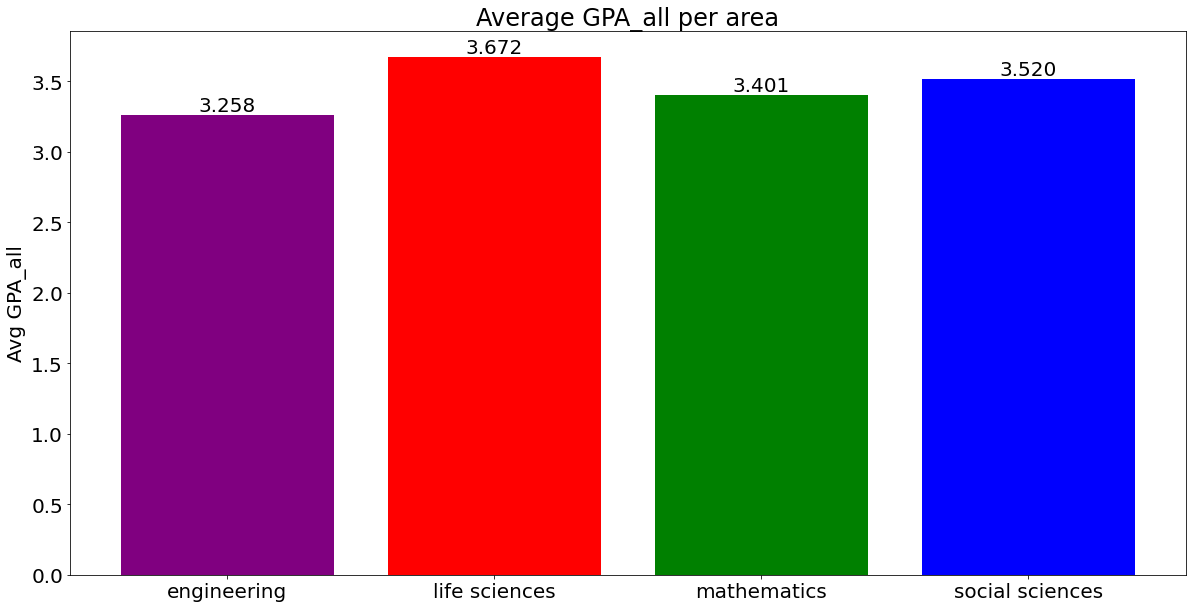

In [76]:
plt.figure(figsize=(20,10))

# Create bars with different colors
plt.bar(avg_grades.index, avg_grades["gpa_all"], color=['purple', 'red', 'green', 'blue'])

# Create names on the x-axis
plt.xticks(avg_grades.index, avg_grades.index)
plt.ylabel("Avg GPA_all")
plt.title('Average GPA_all per area')

for i in range(len(avg_grades["gpa_all"])):
    plt.annotate("{:4.3f}".format(avg_grades["gpa_all"].iloc[i]), xy=(avg_grades.index[i],avg_grades["gpa_all"].iloc[i]), ha='center', va='bottom')


plt.rcParams.update({'font.size': 20})

# Show graph
plt.show()

# Database Systems - Homework Assignment 2 - Part 2